In [5]:
import numpy as np
import pandas as pd
import pickle
import sklearn
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from jupyterthemes import jtplot
from matplotlib.lines import Line2D
import scipy 
from scipy import stats
from tqdm.notebook import tqdm

In [6]:
# np.random.seed(42)
jtplot.reset()
jtplot.reset()

const = 12
SMALL_SIZE = 8 + const  
MEDIUM_SIZE = 10 + const
BIGGER_SIZE = 12 + const

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=20)
np.core.arrayprint._line_width = 1000

# Load Data

In [3]:
from constants import *
from baseline_load_data import data_loader

cbcl_redundant_cols = ['cbcl_q55_p', 'cbcl_q100_p', 'cbcl_q77_p', 'cbcl_q76_p', 'cbcl_q47_p', 'cbcl_q92_p', 'cbcl_q53_p', 'cbcl_q108_p',
                       'cbcl_q99_p', 'cbcl_q105_p', 'cbcl_q101_p'
                      ]  # adding temporarily
cbcl_item_cols_limited = [x for x in cbcl_item_cols if x not in cbcl_redundant_cols]
test_idxs, X, Y, pred_vars, subjectkey, master_df = data_loader(y_cols = sleep_cols, #bpmt_questions,  #(cbcl_item_cols_limited + bpmt_questions), 
                                                     x_cols_to_exclude = upps_item_cols + sleep_cols
                                                                + cbcl_redundant_cols + pf10_cols + g_cols + bpmt_questions + cbcl_item_cols_limited + fitbit_sleep_cols)


# CCA Loadings Visualization

In [10]:
canonical_names = {'cbcl_scr_syn_anxdep_r': 'anxdep',
 'cbcl_scr_syn_withdep_r': 'withdep',
 'cbcl_scr_syn_somatic_r': 'somatic',
 'cbcl_scr_syn_social_r': 'social',
 'cbcl_scr_syn_thought_r': 'thought',
 'cbcl_scr_syn_attention_r': 'attention',
 'cbcl_scr_syn_rulebreak_r': 'rulebreak',
 'cbcl_scr_syn_aggressive_r': 'aggressive',
 'nihtbx_picvocab_uncorrected': 'picvocab',
 'nihtbx_flanker_uncorrected': 'flanker',
 'nihtbx_list_uncorrected': 'list',
 'nihtbx_cardsort_uncorrected': 'cardsort',
 'nihtbx_pattern_uncorrected': 'pattern',
 'nihtbx_picture_uncorrected': 'picture',
 'nihtbx_reading_uncorrected': 'reading',
 'pea_ravlt_sd_trial_iv_tc': 'ravlt short',
 'pea_ravlt_ld_trial_vii_tc': 'ravlt long',
 'pea_wiscv_trs': 'wiscv',
 'lmt_scr_num_correct': 'lmt scr',
 'upps_y_ss_negative_urgency': 'negative urgency',
 'upps_y_ss_lack_of_planning': 'lack of planning',
 'upps_y_ss_sensation_seeking': 'sensation seeking',
 'upps_y_ss_positive_urgency': 'positive urgency',
 'upps_y_ss_lack_of_perseverance': 'lack of perseverance',
 'pps_y_ss_severity_score': 'pps severity',
 'bis_y_ss_bis_sum': 'bis sum',
 'bis_y_ss_bas_rr': 'reward responsiveness',
 'bis_y_ss_bas_drive': 'drive',
 'bis_y_ss_bas_fs': 'fun seeking',
 'srpf_y_ss_ses': 'school environment',
 'srpf_y_ss_iiss': 'school involvement',
 'srpf_y_ss_dfs': 'school disengagement',
 'psb_y_ss_mean': 'prosocial behavior (youth)',
 'fes_y_ss_fc_pr': 'family conflict (youth)',
 'psb_p_ss_mean': 'prosocial behavior (parent)',
 'fes_p_ss_fc_pr': 'family conflict (parent)',
 'reshist_addr1_adi_wsum': 'area deprivation index',
 'EdYearsAverage': 'parental education',
 'demo_comb_income_v2': 'household income',
 'bmi': 'BMI',
 'stq_y_ss_weekday': 'screen time weekday',
 'stq_y_ss_weekend': 'screen time weekend',
 'FHtotal': 'family history psychopath.',
 'medhx_ss_4b_p': 'emerg. room visits (past year)',
 'medhx_ss_5b_p': 'emerg. room visits (before last year)',
 'medhx_2a': 'doctor visit (Asthma)',
 'medhx_2d': 'doctor visit (Bronchitis)',
 'neighborhood1r_p': 'neighborhood safety (walking)',
 'neighborhood2r_p': 'neighborhood safety (violence)',
 'neighborhood3r_p': 'neighborhood safety (crime)',
 'Age': 'age',
 'M': 'sex (M)',
 'Asian': 'race (asian)',
 'Black': 'race (black)',
 'Hispanic': 'race (hispanic)',
 'Other': 'race (other)',
 'not_married': 'parental marital status (not married)',
 'sds_p_ss_dims': 'initiating and maintaining sleep',
 'sds_p_ss_sbd': 'sleep breathing disorders',
 'sds_p_ss_da': 'disorder of arousal',
 'sds_p_ss_swtd': 'sleep-wake transition disorders',
 'sds_p_ss_does': 'disorders of excessive somnolence',
 'sds_p_ss_shy': 'sleep hyperhydrosis'
}

In [13]:
# fit whole-sample model
model = CCA(n_components=2).fit(X, Y)
X_transform, Y_transform = model.transform(X, Y)
for i in range(2):
    canonical_r = scipy.stats.pearsonr(X_transform[:, i], Y_transform[:, i])[0]
    print(f'Canonical Correlation for CV{i+1} is : {canonical_r:.4f}')

Canonical Correlation for CV1 is : 0.6035
Canonical Correlation for CV2 is : 0.2877


In [14]:
pred_var_groupings = {
    'cbcl': cbcl_cols,
    'upps': upps_cols[:-1],
    'bis': bis_cols,
    'nih': nih_cols + pea_cols + lmt_cols,
    'demo': ['bmi', 'Age', 'M', 'Asian', 'Black', 'Hispanic', 'Other', 'not_married',
             'EdYearsAverage', 'demo_comb_income_v2'],
    'pps': ['pps_y_ss_severity_score'],
    'srpf': ['srpf_y_ss_ses', 'srpf_y_ss_iiss', 'srpf_y_ss_dfs'],
    'psb': ['psb_y_ss_mean', 'psb_p_ss_mean'], 
    'fes': ['fes_y_ss_fc_pr', 'fes_p_ss_fc_pr'],
    'screen': ['stq_y_ss_weekday', 'stq_y_ss_weekend'],
    'medical': ['FHtotal', 'medhx_ss_4b_p', 'medhx_ss_5b_p'] + med_cols_2,
    'neigh_safety': neigh_crimes_par_cols,
    'adi': ['reshist_addr1_adi_wsum']
}

domains = {
    'psychopathology': ['cbcl'],
    'personality and other traits': ['upps',
                                     'bis',
                                     'psb',
                                     'pps'][::-1],
    'cognition': ['nih'],
    'demographics and history': ['demo',
                                 'medical'],
    'family, school, and neighborhood': ['srpf',
                                         'fes', 'adi', 'neigh_safety', 'screen'][::-1]
}

for questionnaire in pred_var_groupings:
    assert questionnaire in [x for y in domains.values() for x in y], questionnaire

pred_var_color_mapping = {
    'cbcl': 'C3',
    
    'upps': 'sandybrown',
    'bis': 'tan',
    'psb': 'orange',
    'pps': 'lightcoral',
    
    
    'nih': 'green',

    'demo': 'orchid',
    'medical': 'pink',
    
    'srpf': 'navy',
    'fes': 'royalblue',
    'adi': 'blue',
    'neigh_safety': 'darkslateblue',
    'screen': 'mediumslateblue',
    
    'psychopathology': 'C3',
    'personality and other traits': 'C1',
    'cognition': 'C2',
    'demographics and history': 'orchid',
    'family, school, and neighborhood': 'C0',
    'sleep': 'k'
}

cbcl_var_groupings = {
    'sleep':sleep_cols
}

cbcl_var_color_mapping = {
    'anxdep': 'chartreuse',
    'withdep': 'chocolate',
    'somatic': 'mediumorchid',
    'social': 'deeppink',
    'thought': 'royalblue',
    'attention': 'lightsalmon',
    'rulebreak': 'lightseagreen',
    'aggressive': 'deepskyblue',
    'other': 'crimson',
    'teacher-BPM': 'C2',
    'fitbit_sleep_cols': 'C5',
    'sleep': 'k'

}

In [15]:
[x for x in [a for b in [pred_var_groupings[x] for x in pred_var_groupings] for a in b] if x not in pred_vars]

[]

In [16]:
[x for x in pred_vars if x not in [x for x in [a for b in [pred_var_groupings[x] for x in pred_var_groupings] for a in b]]]

[]

In [17]:
# generate bootstraps for CCA loadings
bootstap_x_loadings = np.zeros((10000, X.shape[1], 2))
bootstap_y_loadings = np.zeros((10000, Y.shape[1], 2))

np.random.seed(42)
for boot_i in tqdm(range(10000), ncols=1000):
    boot_idxs = np.random.choice(np.arange(X.shape[0]), replace=True, size=X.shape[0])
    boot_model = CCA(n_components=2).fit(X[boot_idxs, :], Y[boot_idxs, :])
    bootstap_x_loadings[boot_i, :] = boot_model.x_rotations_
    bootstap_y_loadings[boot_i, :] = boot_model.y_rotations_

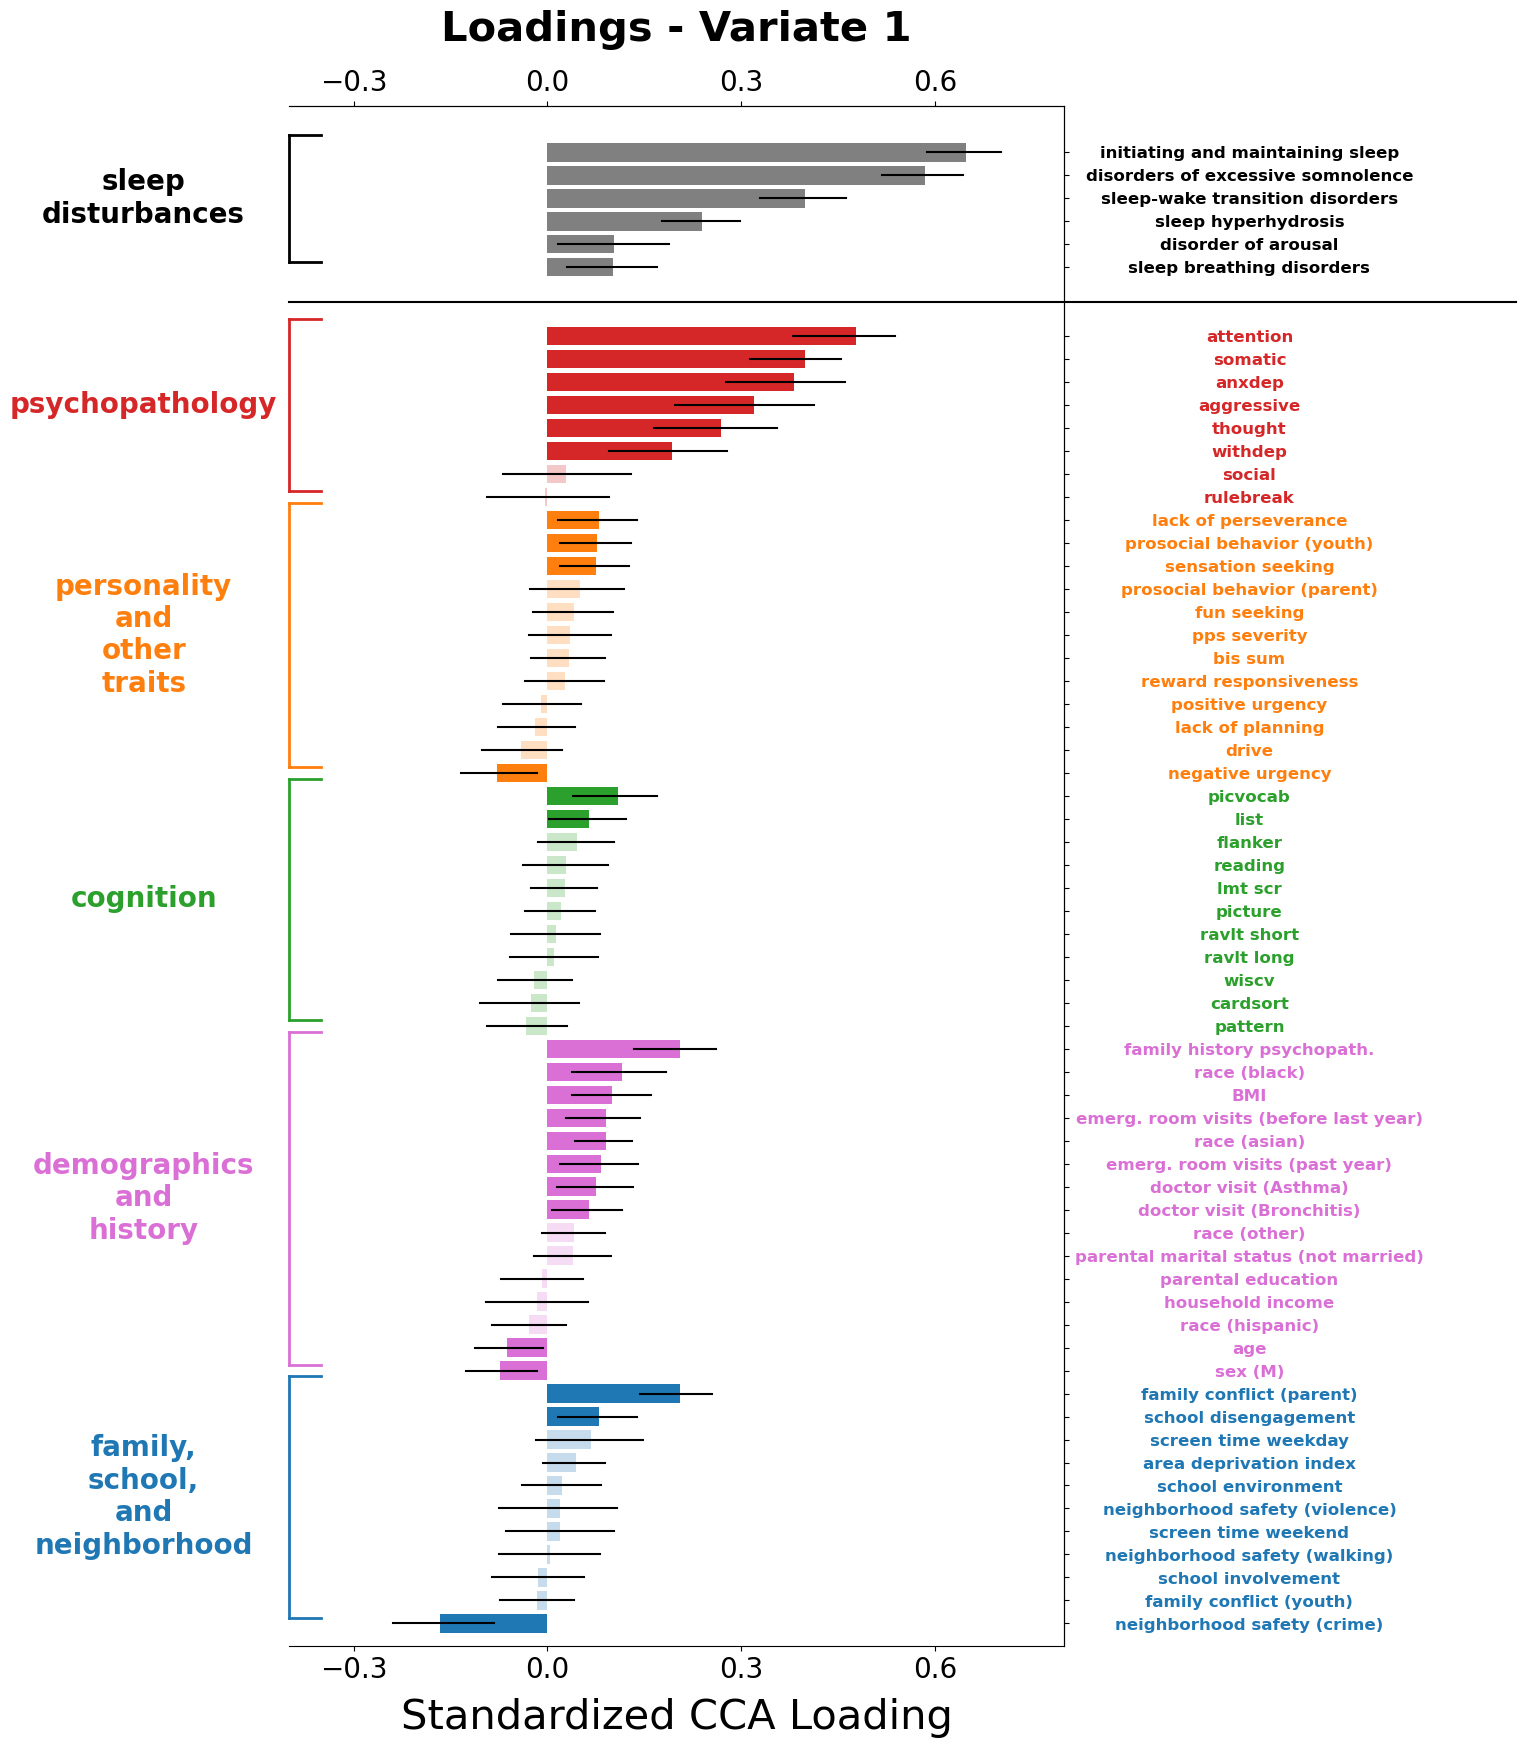

In [28]:
x_ordering = dict()
pheno = []
beta = []
se = []
lower_95_ci = []
upper_95_ci = []

for cv_i in [0]:
    # set up figure
    fig = plt.figure(figsize=(10, 20))
    ax1 = plt.gca()
    
    # get sign flip figure
    sign_flip = np.sign(np.sum(model.x_rotations_[:, cv_i]))
    
    '''
    Plot X Loadings
    '''
    
    # plot all variable loadings based on significance
    running_idx = 0
    tick_labels = []
    tick_colors = []
    
    ind_X = np.arange(X.shape[1])  # + max(ind_Y) + 1
    #for key, val in pred_var_groupings.items():
    for domain in list(domains.keys())[::-1]:
        domain_idx_start = running_idx
        domain_var_idxs = []
        domain_tmp_labs = []
        for key in domains[domain]:
            val = pred_var_groupings[key]
            if key != 'demo':
                val = [v for v in val if v in master_df.columns]
                if len(val) == 0: 
                    print(f'skipping {key}...')
                    continue
            var_idxs = [i for i,x in enumerate(pred_vars) if x in val]
            tmp_labs = [x for x in pred_vars if x in val]
            
            domain_var_idxs.extend(var_idxs)
            domain_tmp_labs.extend(tmp_labs)
            
        var_idxs = domain_var_idxs
        tmp_labs = domain_tmp_labs
        
        sort_order = np.argsort(model.x_rotations_[var_idxs, cv_i])
        x_ordering[domain] = (sort_order, var_idxs, [canonical_names[tmp_labs[i]] for i in sort_order])
        var_idxs = np.array(var_idxs)[sort_order]
        tmp_labs = [canonical_names[tmp_labs[i]] for i in sort_order]

        for var_idx, running_x in zip(var_idxs, np.arange(running_idx, running_idx + len(var_idxs))):
            boot_vals = bootstap_x_loadings[:, var_idx, cv_i]
            lower_val, upper_val = np.percentile(boot_vals, 2.5), np.percentile(boot_vals, 97.5)
            is_sig = False
            if lower_val < 0  and upper_val < 0:
                is_sig = True
            if lower_val > 0  and upper_val > 0:
                is_sig = True
            ax1.plot([lower_val, upper_val], [running_x, running_x], c='k', linewidth=1.5)
            ax1.barh(running_x, model.x_rotations_[var_idx, cv_i] * sign_flip, 
                     color=pred_var_color_mapping[domain], alpha=1 if is_sig else 0.25)
            tick_colors.append(pred_var_color_mapping[domain])  #[key])
            
            beta.append(model.x_rotations_[var_idx, cv_i] * sign_flip)
            se.append(np.std(boot_vals))
            lower_95_ci.append(lower_val)
            upper_95_ci.append(upper_val)
        
        pheno.extend(tmp_labs)
        tick_labels += tmp_labs
        running_idx += len(var_idxs)

        bracket_x = -0.4  #0.775
        x1, x2 = bracket_x, bracket_x+0.05   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y1, y2, h, col = domain_idx_start+0.25, running_idx-0.25, 0.5, pred_var_color_mapping[domain]
        plt.plot([x1, x1], [y1, y2], lw=2, c=col, clip_on=False)
        plt.plot([x1, x2], [y1, y1], lw=2, c=col, clip_on=False)
        plt.plot([x1, x2], [y2, y2], lw=2, c=col, clip_on=False)
        plt.text((x1+x2)/2 - 0.25, (y1+y2)/2, 
                 domain.replace(' ', '\n'),
                 ha='center', va='center', color=col, fontweight='bold')
                    
            
    ax1.barh([running_idx], [0], color='white', alpha=0)
    running_idx += 1
    
    ax1.barh([running_idx], [0], color='white', alpha=0)
    running_idx += 1
    
    
    ind_Y = np.arange(Y.shape[1]) + max(ind_X) + 1 + 2
    for key, val in cbcl_var_groupings.items():
        domain_idx_start = running_idx
        
        var_idxs = [i for i,x in enumerate(sleep_cols) if x in val]
        tmp_labs = [x for x in sleep_cols if x in val]
        
        sort_order = np.argsort(model.y_rotations_[var_idxs, cv_i])
        x_ordering[key] = (sort_order, var_idxs, [canonical_names[tmp_labs[i]] for i in sort_order])
        var_idxs = np.array(var_idxs)[sort_order]
        tmp_labs = [canonical_names[tmp_labs[i]] for i in sort_order]
        
        for var_idx, running_x in zip(var_idxs, np.arange(running_idx, running_idx + len(var_idxs))):
            boot_vals = bootstap_y_loadings[:, var_idx, cv_i]
            lower_val, upper_val = np.percentile(boot_vals, 2.5), np.percentile(boot_vals, 97.5)
            is_sig = False
            if lower_val < 0  and upper_val < 0:
                is_sig = True
            if lower_val > 0  and upper_val > 0:
                is_sig = True
            ax1.plot([lower_val, upper_val], [running_x, running_x], c='k', linewidth=1.5)
            ax1.barh(running_x, model.y_rotations_[var_idx, cv_i] * sign_flip, 
                     color='gray', alpha=1 if is_sig else 0.25)
            tick_colors.append('k')
            
            beta.append(model.y_rotations_[var_idx, cv_i] * sign_flip)
            se.append(np.std(boot_vals))
            lower_95_ci.append(lower_val)
            upper_95_ci.append(upper_val)
        
        pheno.extend(tmp_labs)
        tick_labels += tmp_labs
        running_idx += len(var_idxs)
        
        
        bracket_x = -0.4  #0.775
        x1, x2 = bracket_x, bracket_x+0.05
        y1, y2, h, col = domain_idx_start+0.25, running_idx-0.25, 0.5, pred_var_color_mapping[key]
        plt.plot([x1, x1], [y1, y2], lw=2, c=col, clip_on=False)
        plt.plot([x1, x2], [y1, y1], lw=2, c=col, clip_on=False)
        plt.plot([x1, x2], [y2, y2], lw=2, c=col, clip_on=False)
        plt.text((x1+x2)/2 - 0.25, (y1+y2)/2, 
                 'sleep\ndisturbances',
                 ha='center', va='center', color=col, fontweight='bold')
        


    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.yaxis.tick_right()

    ax1.set_yticks(list(ind_X) + list(ind_Y)) 
    ax1.get_yaxis().set_tick_params(pad=130)
    ax1.set_yticklabels(tick_labels, fontsize=12, ha='center', fontweight='bold')
    for color, tick in zip(tick_colors, ax1.get_yticklabels()):
        tick.set_color(color)

    
    ax2 = ax1.twiny()
    ax2.spines['left'].set_visible(False)
    
    ax1.set_xlim((-0.4, 0.8))
    ax2.set_xlim((-0.4, 0.8))
    ax1.set_xticks(np.arange(-0.3, 0.7, 0.3))
    ax2.set_xticks(np.arange(-0.3, 0.7, 0.3))
    ax1.set_ylim((-1, running_idx+1))
    
    plt.title(f'Loadings - Variate {cv_i + 1}', fontsize=30, fontweight='bold', pad=20)
    ax1.set_xlabel(f'Standardized CCA Loading', fontsize=30, labelpad=10)
    
    
    break_x = max(list(ind_X) + list(ind_Y)) - Y.shape[1] - 0.5
    line = Line2D([-0.4, 1.5], [break_x, break_x], lw=1.5, color='k', alpha=1)
    line.set_clip_on(False)
    ax1.add_line(line)
    

    plt.show()

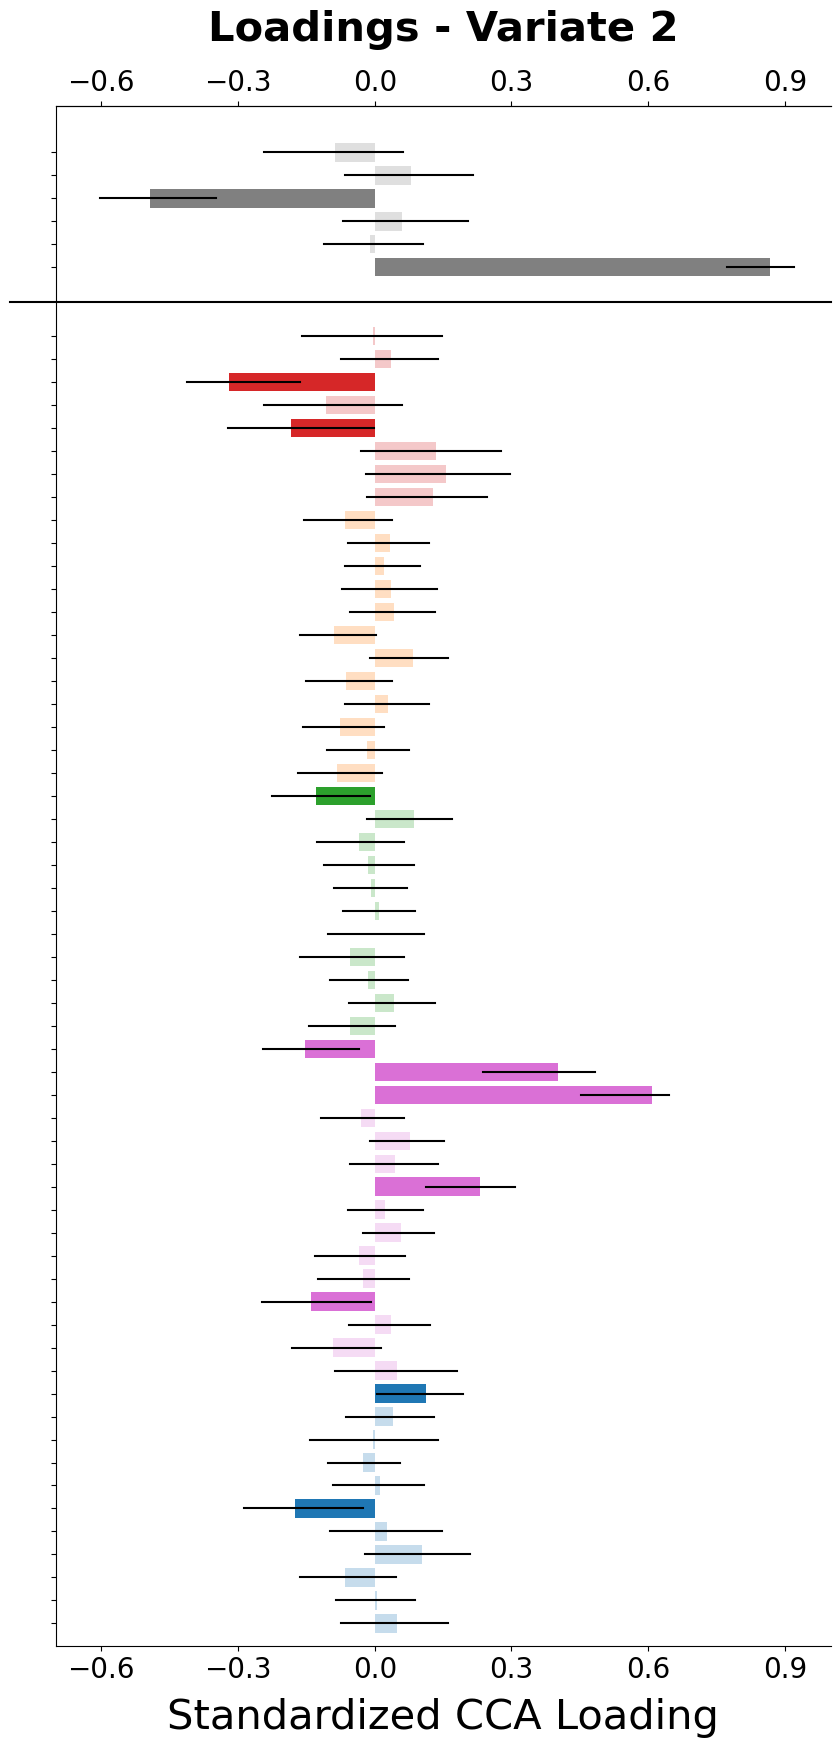

In [30]:
pheno2 = []
beta2 = []
se2 = []
lower_95_ci2 = []
upper_95_ci2 = []

for cv_i in [1]:
    # set up figure
    fig = plt.figure(figsize=(10, 20))
    ax1 = plt.gca()
    
    # get sign flip figure
    sign_flip = np.sign(np.sum(model.x_rotations_[:, cv_i]))
    
    '''
    Plot X Loadings
    '''
    
    # plot all variable loadings based on significance
    running_idx = 0
    tick_labels = []
        
    
    ind_X = np.arange(X.shape[1])  
    for domain in list(domains.keys())[::-1]:
        domain_idx_start = running_idx
        domain_var_idxs = []
        domain_tmp_labs = []
        for key in domains[domain]:
            val = pred_var_groupings[key]
            if key != 'demo':
                val = [v for v in val if v in master_df.columns]
                if len(val) == 0: 
                    print(f'skipping {key}...')
                    continue
            var_idxs = [i for i,x in enumerate(pred_vars) if x in val]
            tmp_labs = [x for x in pred_vars if x in val]
            
            domain_var_idxs.extend(var_idxs)
            domain_tmp_labs.extend(tmp_labs)
            
        var_idxs = domain_var_idxs
        tmp_labs = domain_tmp_labs
        sort_order, saved_var_idxs, sorted_tmp_labs = x_ordering[domain] 
        assert np.all(np.array(var_idxs) == np.array(saved_var_idxs))
        var_idxs = np.array(var_idxs)[sort_order]
        tmp_labs = [canonical_names[tmp_labs[i]] for i in sort_order]
        assert np.all(np.array(sorted_tmp_labs) == np.array(tmp_labs))

        for var_idx, running_x in zip(var_idxs, np.arange(running_idx, running_idx + len(var_idxs))):
            boot_vals = bootstap_x_loadings[:, var_idx, cv_i]
            lower_val, upper_val = np.percentile(boot_vals, 2.5), np.percentile(boot_vals, 97.5)
            is_sig = False
            if lower_val < 0  and upper_val < 0:
                is_sig = True
            if lower_val > 0  and upper_val > 0:
                is_sig = True
            ax1.plot([lower_val, upper_val], [running_x, running_x], c='k', linewidth=1.5)
            ax1.barh(running_x, model.x_rotations_[var_idx, cv_i] * sign_flip, 
                     color=pred_var_color_mapping[domain], alpha=1 if is_sig else 0.25)
            
            beta2.append(model.x_rotations_[var_idx, cv_i] * sign_flip)
            se2.append(np.std(boot_vals))
            lower_95_ci2.append(lower_val)
            upper_95_ci2.append(upper_val)
        
        pheno2.extend(tmp_labs)

            
        tick_labels += tmp_labs
        running_idx += len(var_idxs)
            
            
    ax1.barh([running_idx], [0], color='white', alpha=0)
    running_idx += 1
    
    ax1.barh([running_idx], [0], color='white', alpha=0)
    running_idx += 1
    
    
    ind_Y = np.arange(Y.shape[1]) + max(ind_X) + 1 + 2
    for key, val in cbcl_var_groupings.items():
        domain_idx_start = running_idx
        
        var_idxs = [i for i,x in enumerate(sleep_cols) if x in val]
        tmp_labs = [x for x in sleep_cols if x in val]
        sort_order, saved_var_idxs, sorted_tmp_labs = x_ordering[key]
        assert np.all(np.array(var_idxs) == np.array(saved_var_idxs))
        var_idxs = np.array(var_idxs)[sort_order]
        tmp_labs = [canonical_names[tmp_labs[i]] for i in sort_order]
        assert np.all(np.array(sorted_tmp_labs) == np.array(tmp_labs))
        
        for var_idx, running_x in zip(var_idxs, np.arange(running_idx, running_idx + len(var_idxs))):
            boot_vals = bootstap_y_loadings[:, var_idx, cv_i]
            lower_val, upper_val = np.percentile(boot_vals, 2.5), np.percentile(boot_vals, 97.5)
            is_sig = False
            if lower_val < 0  and upper_val < 0:
                is_sig = True
            if lower_val > 0  and upper_val > 0:
                is_sig = True
            ax1.plot([lower_val, upper_val], [running_x, running_x], c='k', linewidth=1.5)
            ax1.barh(running_x, model.y_rotations_[var_idx, cv_i] * sign_flip, 
                     color='gray', alpha=1 if is_sig else 0.25)
            
            beta2.append(model.y_rotations_[var_idx, cv_i] * sign_flip)
            se2.append(np.std(boot_vals))
            lower_95_ci2.append(lower_val)
            upper_95_ci2.append(upper_val)
        
        pheno2.extend(tmp_labs)

        
        tick_labels += tmp_labs
        running_idx += len(var_idxs)
        


    ax1.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_yticks(list(ind_X) + list(ind_Y))  
    ax1.set_yticklabels([])
    
    ax2 = ax1.twiny()
    ax2.spines['right'].set_visible(False)
    ax1.set_xlim((-0.7, 1))
    ax2.set_xlim((-0.7, 1))
    ax1.set_xticks(np.arange(-0.6, 1, 0.3))
    ax2.set_xticks(np.arange(-0.6, 1, 0.3))
    ax1.set_ylim((-1, running_idx+1))
    ax2.spines['left'].set_visible(False)
    
    plt.title(f'Loadings - Variate {cv_i + 1}', fontsize=30, fontweight='bold', pad=20)
    ax1.set_xlabel(f'Standardized CCA Loading', fontsize=30, labelpad=10)
    
    break_x = max(list(ind_X) + list(ind_Y)) - Y.shape[1] - 0.5
    line = Line2D([-0.8, 1], [break_x, break_x], lw=1.5, color='k', alpha=1)
    line.set_clip_on(False)
    ax1.add_line(line)
    

    plt.show()

# Leave One Site Out CCA Performance

In [ ]:
assert X.shape[0] == master_df.shape[0]
unique_sites = master_df.site_id_l.unique()

site_idxs = []
for site_i, test_site in enumerate(tqdm(unique_sites, ncols=1000)):
    test_idxs = np.argwhere(master_df.site_id_l.values.flatten() == test_site).flatten()
    train_idxs = np.array([x for x in np.arange(master_df.shape[0]) if x not in test_idxs])
    site_idxs.append((train_idxs, test_idxs))
    
    
oos_rs = np.zeros((len(unique_sites), 2))

for site_i, (train_idxs, test_idxs) in enumerate(tqdm(site_idxs, ncols=1000)):    
    model = CCA(n_components=2).fit(X[train_idxs, :], Y[train_idxs, :])
    X_transform, Y_transform = model.transform(X[test_idxs, :], Y[test_idxs, :])
    oos_rs[site_i, 0] = scipy.stats.pearsonr(X_transform[:, 0], Y_transform[:, 0])[0]
    oos_rs[site_i, 1] = scipy.stats.pearsonr(X_transform[:, 1], Y_transform[:, 1])[0]
    
print(oos_rs.mean(0))

# CCA Loadings Permutations

In [ ]:
perm_subs, perm_idxs = pickle.load(open(PATH_TO_BLOCK_PERM_IDXS + 'subs_perms_baseline_10k.pickle', 'rb'))
assert np.all(np.array(perm_subs) == master_df.subjectkey.values.flatten())
perm_idxs = perm_idxs - 1
assert perm_idxs.min() == 0
perm_idxs.shape

n_perms = 10000
perm_oos_rs = np.zeros((n_perms, 2))

for perm_i in tqdm(range(n_perms)):
    oos_rs = np.zeros((len(unique_sites), 2))
    Y_perm = Y[perm_idxs[:, perm_i], :]
    for site_i, (train_idxs, test_idxs) in enumerate(site_idxs):    
        model = CCA(n_components=2).fit(X[train_idxs, :], Y_perm[train_idxs, :])
        X_transform, Y_transform = model.transform(X[test_idxs, :], Y_perm[test_idxs, :])
        oos_rs[site_i, 0] = scipy.stats.pearsonr(X_transform[:, 0], Y_transform[:, 0])[0]
        oos_rs[site_i, 1] = scipy.stats.pearsonr(X_transform[:, 1], Y_transform[:, 1])[0]
    perm_res = oos_rs.mean(0)
    perm_oos_rs[perm_i, :] = perm_res
    
pickle.dump(perm_oos_rs, open('./perms_baseline.pickle', 'wb'))